# Capacity allocation

In [2]:
!python3 -m pip install -e /home/oreto2024/PycharmProjects/robin

Obtaining file:///home/oreto2024/PycharmProjects/robin
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for robin (pyproject.toml) ... done
  Created wheel for robin: filename=robin-0.0.post1.dev693+g09e8b4e-0.editable-py3-none-any.whl size=4671 sha256=a712e887bbdff0e7e9c63789f3f917da7d67d158678c4afc64ae2f88bccc53f5
  Stored in directory: /tmp/pip-ephem-wheel-cache-4075o6oz/wheels/c6/48/3a/80585332bc876223c19a86be895920efe423de99b02bf42862
Successfully built robin


## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behavior, get_revenue_behavior_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution
from src.timetabling_problem import MPTT

from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from mealpy.evolutionary_based import GA
from mealpy import IntegerVar
from pathlib import Path
import shutil
from typing import Any, List, Mapping, Tuple, Union

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [3]:
frame_capacity = {'1': 0.55, '2': 0.25, '3': 0.1, '4': 0.05, '5': 0.05}

n_services = 50
n_services_by_ru = {ru: round(cap * n_services) for ru, cap in frame_capacity.items()}

n_services_by_ru

{'1': 28, '2': 12, '3': 5, '4': 2, '5': 2}

In [4]:
seed = 21

if generator_config_path:
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services_by_ru=n_services_by_ru,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 49


In [5]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)
print(tsp_df)

     Number of Services
RU1                  28
RU2                  12
RU3                   5
RU4                   2
RU5                   2


In [6]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behavior = get_revenue_behavior_deprecated(supply)
lines = supply.lines
line = infer_line_stations(lines)

Services:  49


In [7]:
n_services = sum(tsp_df["Number of Services"].values)

services_by_ru = {}
for service in revenue_behavior:
    if revenue_behavior[service]['ru'] not in services_by_ru:
        services_by_ru[revenue_behavior[service]['ru']] = 1
    else:
        services_by_ru[revenue_behavior[service]['ru']] += 1

services_by_ru = {f"RU{k}": v for k, v in services_by_ru.items()}
print(services_by_ru)

frame_capacity = {ru: round(services_by_ru[ru] / n_services * 100, 2) for ru in services_by_ru}
print(frame_capacity)

{'RU1': 28, 'RU2': 12, 'RU3': 5, 'RU4': 2, 'RU5': 2}
{'RU1': 57.14, 'RU2': 24.49, 'RU3': 10.2, 'RU4': 4.08, 'RU5': 4.08}


C:\Users\hyper\PycharmProjects\GSA_M\.venv\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


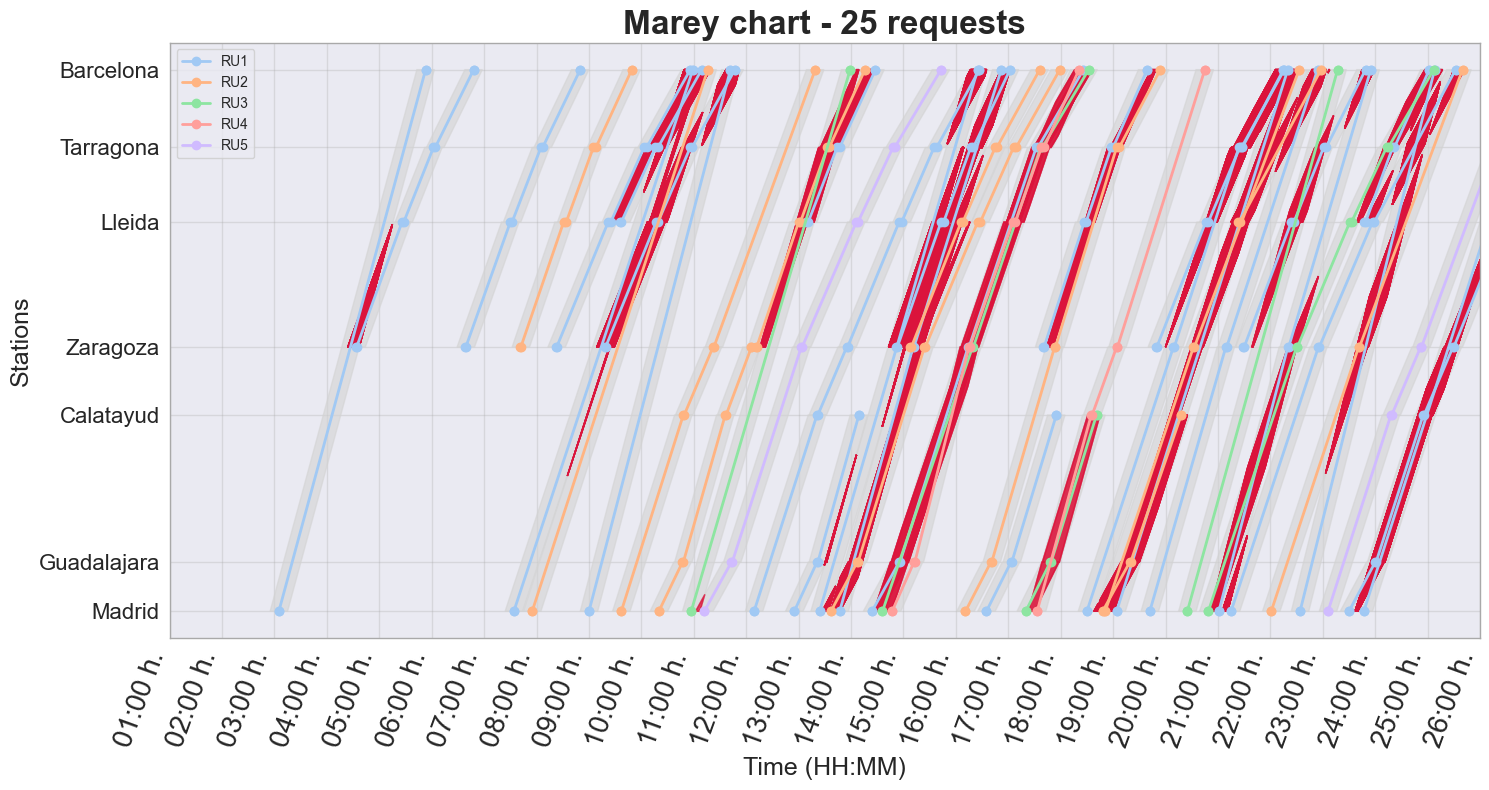

In [8]:
plot_marey_chart(requested_supply=supply,
                 colors_by_tsp=True, 
                 main_title="Marey chart - 25 requests",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_requests_25.pdf'))

## 1. Mealpy

## 2. Results analysis

In [9]:
reports_path = '../reports/mealpy/alpha/*'

In [10]:
# List files in reports path dir
import glob

file_names = glob.glob(reports_path)

In [11]:
print(file_names)

['../reports/mealpy/alpha\\df_history_equity_atkinson_e2_28_mar_alpha1.csv', '../reports/mealpy/alpha\\df_history_equity_atkinson_e2_28_mar_alpha10.csv', '../reports/mealpy/alpha\\df_history_equity_atkinson_e2_28_mar_alpha25.csv', '../reports/mealpy/alpha\\df_history_equity_atkinson_e2_28_mar_alpha5.csv', '../reports/mealpy/alpha\\df_history_equity_atkinson_e2_28_mar_alpha50.csv', '../reports/mealpy/alpha\\df_population_equity_atkinson_e2_28_mar_alpha1.csv', '../reports/mealpy/alpha\\df_population_equity_atkinson_e2_28_mar_alpha10.csv', '../reports/mealpy/alpha\\df_population_equity_atkinson_e2_28_mar_alpha25.csv', '../reports/mealpy/alpha\\df_population_equity_atkinson_e2_28_mar_alpha5.csv', '../reports/mealpy/alpha\\df_population_equity_atkinson_e2_28_mar_alpha50.csv']


In [12]:
import pandas as pd
from pathlib import Path

global_df_history = pd.DataFrame()
global_df_population = pd.DataFrame()

for file_name in file_names:
    print(f"Leyendo: {file_name}")
    # Extraer el valor de alpha del nombre del archivo
    try:
        alpha_value = int(Path(file_name).stem.split("alpha")[1].split(".")[0])
        print(alpha_value)
    except (IndexError, ValueError):
        print(f"Error al extraer alpha de {file_name}")
        continue  # Saltar archivos que no cumplan con el formato esperado

    # Leer el dataframe correspondiente y añadir la columna "alpha"
    if 'history' in file_name:
        df_history = pd.read_csv(file_name, sep=";")
        df_history["alpha"] = alpha_value
        global_df_history = pd.concat([global_df_history, df_history], ignore_index=True)
    elif 'population' in file_name:
        df_population = pd.read_csv(file_name, sep=";")
        df_population["alpha"] = alpha_value
        global_df_population = pd.concat([global_df_population, df_population], ignore_index=True)


Leyendo: ../reports/mealpy/alpha\df_history_equity_atkinson_e2_28_mar_alpha1.csv
1
Leyendo: ../reports/mealpy/alpha\df_history_equity_atkinson_e2_28_mar_alpha10.csv
10
Leyendo: ../reports/mealpy/alpha\df_history_equity_atkinson_e2_28_mar_alpha25.csv
25
Leyendo: ../reports/mealpy/alpha\df_history_equity_atkinson_e2_28_mar_alpha5.csv
5
Leyendo: ../reports/mealpy/alpha\df_history_equity_atkinson_e2_28_mar_alpha50.csv
50
Leyendo: ../reports/mealpy/alpha\df_population_equity_atkinson_e2_28_mar_alpha1.csv
1
Leyendo: ../reports/mealpy/alpha\df_population_equity_atkinson_e2_28_mar_alpha10.csv
10
Leyendo: ../reports/mealpy/alpha\df_population_equity_atkinson_e2_28_mar_alpha25.csv
25
Leyendo: ../reports/mealpy/alpha\df_population_equity_atkinson_e2_28_mar_alpha5.csv
5
Leyendo: ../reports/mealpy/alpha\df_population_equity_atkinson_e2_28_mar_alpha50.csv
50


In [13]:
global_df_history

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration,alpha
0,1,Atkinson,0,2166.471141,0.861707,[ True True True True False False False Fal...,[1021. 1114. 1146. 1446. 1445. 1504. 1533. 159...,11.692756,0.000000,100.000000,1
1,1,Atkinson,1,2842.763785,0.870681,[ True False False True False False False Tr...,[1021. 1114. 1145. 1446. 1442. 1504. 1538. 159...,11.545669,1.257929,98.742071,1
2,1,Atkinson,2,2842.763785,0.868285,[ True False False True False False False Tr...,[1021. 1114. 1145. 1446. 1442. 1504. 1538. 159...,11.128661,4.824307,95.175693,1
3,1,Atkinson,3,2842.763785,0.863926,[ True False False True False False False Tr...,[1021. 1114. 1145. 1446. 1442. 1504. 1538. 159...,9.668031,17.316058,82.683942,1
4,1,Atkinson,4,2842.763785,0.871023,[ True False False True False False False Tr...,[1021. 1114. 1145. 1446. 1442. 1504. 1538. 159...,9.162677,21.638002,78.361998,1
...,...,...,...,...,...,...,...,...,...,...,...
2495,5,Atkinson,95,3279.549609,0.868898,[ True True True True False False False Tr...,[1061. 1111. 1147. 1410. 1449. 1504. 1532. 159...,2.391496,79.887425,20.112575,50
2496,5,Atkinson,96,3279.549609,0.860589,[ True True True True False False False Tr...,[1061. 1111. 1147. 1410. 1449. 1504. 1532. 159...,2.181417,81.654195,18.345805,50
2497,5,Atkinson,97,3531.314563,0.885554,[ True True True True False False False Tr...,[1061. 1111. 1142. 1410. 1441. 1498. 1532. 159...,2.094961,82.381299,17.618701,50
2498,5,Atkinson,98,3592.416801,0.851418,[ True True True True False False False Tr...,[1061. 1111. 1142. 1410. 1441. 1498. 1532. 159...,2.152598,81.896563,18.103437,50


In [14]:
global_df_population

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49,alpha
0,1,Atkinson,0,[1096. 1115. 1144. 1383. 1444. 1501. 1531. 159...,[1075. 1114. 1147. 1456. 1443. 1502. 1532. 159...,[1033. 1111. 1143. 1407. 1447. 1502. 1530. 159...,[1072. 1114. 1143. 1382. 1443. 1505. 1530. 159...,[1096. 1113. 1144. 1407. 1444. 1501. 1531. 159...,[1075. 1114. 1147. 1456. 1443. 1502. 1532. 159...,[1039. 1115. 1141. 1416. 1446. 1505. 1539. 159...,...,[ True False True True False False False Fal...,[ True False True False False False False Tr...,[ True False True True True False False Tr...,[False False True False False False False Tr...,[ True True True False False False False Tr...,[False True True False False False False Fal...,[False True True True False False False Tr...,[False False True False False False False Fal...,[False True True False False False False Fal...,1
1,1,Atkinson,1,[1041. 1114. 1147. 1446. 1445. 1504. 1533. 159...,[1021. 1115. 1146. 1407. 1445. 1504. 1534. 159...,[1041. 1114. 1147. 1457. 1447. 1497. 1533. 159...,[1026. 1116. 1146. 1407. 1445. 1504. 1534. 159...,[1029. 1113. 1146. 1407. 1444. 1504. 1532. 159...,[1096. 1114. 1144. 1446. 1448. 1501. 1531. 159...,[1096. 1114. 1144. 1407. 1444. 1501. 1531. 159...,...,[ True True True False False False False Tr...,[ True False True False False False False Fal...,[ True True True False False False False Tr...,[ True False True True False False False Tr...,[ True False True True False False False Fal...,[ True False True True False False False Tr...,[ True True True False False False False Tr...,[ True True True False False False False Tr...,[ True True True False False False False Fal...,1
2,1,Atkinson,2,[1096. 1114. 1143. 1407. 1444. 1501. 1531. 159...,[1033. 1114. 1144. 1407. 1447. 1502. 1530. 159...,[1021. 1114. 1146. 1446. 1442. 1504. 1533. 159...,[1033. 1111. 1143. 1446. 1444. 1501. 1533. 159...,[1096. 1114. 1143. 1446. 1447. 1501. 1531. 159...,[1033. 1114. 1144. 1407. 1444. 1497. 1532. 159...,[1041. 1114. 1147. 1446. 1445. 1504. 1533. 159...,...,[ True True True False False False False Tr...,[ True True True True False False False Tr...,[False False True False False False False Fal...,[ True False False True False False False Fal...,[ True False True True False False False Tr...,[ True True True False False False False Tr...,[ True True True False False False False Tr...,[ True True True False False False False Tr...,[ True True True False False False False Tr...,1
3,1,Atkinson,3,[1026. 1114. 1145. 1457. 1447. 1497. 1530. 159...,[1033. 1114. 1144. 1407. 1447. 1502. 1530. 159...,[1021. 1114. 1143. 1446. 1442. 1504. 1533. 159...,[1033. 1114. 1145. 1407. 1447. 1502. 1538. 159...,[1071. 1114. 1145. 1437. 1442. 1501. 1538. 159...,[1021. 1116. 1145. 1457. 1444. 1500. 1538. 159...,[1021. 1110. 1145. 1437. 1443. 1504. 1538. 159...,...,[False True True False False False False Tr...,[ True False True False False False False Tr...,[False True True True False False False Tr...,[ True True True True False False False Tr...,[ True True True True False False False Tr...,[ True False True False False True False Fal...,[False True True True False False False Fal...,[False True True True False False False Fal...,[ True True True True False False False Tr...,1
4,1,Atkinson,4,[1033. 1114. 1145. 1407. 1447. 1504. 1530. 159...,[1021. 1110. 1146. 1437. 1443. 1502. 1538. 159...,[1026. 1114. 1146. 1407. 1442. 1497. 1538. 159...,[1026. 1114. 1145. 1457. 1442. 1500. 1532. 159...,[1069. 1114. 1146. 1407. 1447. 1503. 1530. 159...,[1026. 1116. 1144. 1457. 1444. 1501. 1531. 159...,[1069. 1114. 1146. 1407. 1442. 1497. 1533. 159...,...,[ True False True False False True False Fal...,[ True True True True False False False Tr...,[ True True True True False False False Tr...,[ True False True True False False False Tr...,[False True True True False False False Fal...,[ True True True Tr

In [15]:
df_population = global_df_population
df_history = global_df_history

In [16]:
columns_to_transform = df_population.filter(like="real_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(float, x[1:-1].split())))
)

df_population.head()

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49,alpha
0,1,Atkinson,0,"[1096.0, 1115.0, 1144.0, 1383.0, 1444.0, 1501....","[1075.0, 1114.0, 1147.0, 1456.0, 1443.0, 1502....","[1033.0, 1111.0, 1143.0, 1407.0, 1447.0, 1502....","[1072.0, 1114.0, 1143.0, 1382.0, 1443.0, 1505....","[1096.0, 1113.0, 1144.0, 1407.0, 1444.0, 1501....","[1075.0, 1114.0, 1147.0, 1456.0, 1443.0, 1502....","[1039.0, 1115.0, 1141.0, 1416.0, 1446.0, 1505....",...,[ True False True True False False False Fal...,[ True False True False False False False Tr...,[ True False True True True False False Tr...,[False False True False False False False Tr...,[ True True True False False False False Tr...,[False True True False False False False Fal...,[False True True True False False False Tr...,[False False True False False False False Fal...,[False True True False False False False Fal...,1
1,1,Atkinson,1,"[1041.0, 1114.0, 1147.0, 1446.0, 1445.0, 1504....","[1021.0, 1115.0, 1146.0, 1407.0, 1445.0, 1504....","[1041.0, 1114.0, 1147.0, 1457.0, 1447.0, 1497....","[1026.0, 1116.0, 1146.0, 1407.0, 1445.0, 1504....","[1029.0, 1113.0, 1146.0, 1407.0, 1444.0, 1504....","[1096.0, 1114.0, 1144.0, 1446.0, 1448.0, 1501....","[1096.0, 1114.0, 1144.0, 1407.0, 1444.0, 1501....",...,[ True True True False False False False Tr...,[ True False True False False False False Fal...,[ True True True False False False False Tr...,[ True False True True False False False Tr...,[ True False True True False False False Fal...,[ True False True True False False False Tr...,[ True True True False False False False Tr...,[ True True True False False False False Tr...,[ True True True False False False False Fal...,1
2,1,Atkinson,2,"[1096.0, 1114.0, 1143.0, 1407.0, 1444.0, 1501....","[1033.0, 1114.0, 1144.0, 1407.0, 1447.0, 1502....","[1021.0, 1114.0, 1146.0, 1446.0, 1442.0, 1504....","[1033.0, 1111.0, 1143.0, 1446.0, 1444.0, 1501....","[1096.0, 1114.0, 1143.0, 1446.0, 1447.0, 1501....","[1033.0, 1114.0, 1144.0, 1407.0, 1444.0, 1497....","[1041.0, 1114.0, 1147.0, 1446.0, 1445.0, 1504....",...,[ True True True False False False False Tr...,[ True True True True False False False Tr...,[False False True False False False False Fal...,[ True False False True False False False Fal...,[ True False True True False False False Tr...,[ True True True False False False False Tr...,[ True True True False False False False Tr...,[ True True True False False False False Tr...,[ True True True False False False False Tr...,1
3,1,Atkinson,3,"[1026.0, 1114.0, 1145.0, 1457.0, 1447.0, 1497....","[1033.0, 1114.0, 1144.0, 1407.0, 1447.0, 1502....","[1021.0, 1114.0, 1143.0, 1446.0, 1442.0, 1504....","[1033.0, 1114.0, 1145.0, 1407.0, 1447.0, 1502....","[1071.0, 1114.0, 1145.0, 1437.0, 1442.0, 1501....","[1021.0, 1116.0, 1145.0, 1457.0, 1444.0, 1500....","[1021.0, 1110.0, 1145.0, 1437.0, 1443.0, 1504....",...,[False True True False False False False Tr...,[ True False True False False False False Tr...,[False True True True False False False Tr...,[ True True True True False False False Tr...,[ True True True True False False False Tr...,[ True False True False False True False Fal...,[False True True True False False False Fal...,[False True True True False False False Fal...,[ True True True True False False False Tr...,1
4,1,Atkinson,4,"[1033.0, 1114.0, 1145.0, 1407.0, 1447.0, 1504....","[1021.0, 1110.0, 1146.0, 1437.0, 1443.0, 1502....","[1026.0, 1114.0, 1146.0, 1407.0, 1442.0, 1497....","[1026.0, 1114.0, 1145.0, 1457.0, 1442.0, 1500....","[1069.0, 1114.0, 1146.0, 1407.0, 1447.0, 1503....","[1026.0, 1116.0, 1144.0, 1457.0, 1444.0, 1501....","[1069.0, 1114.0, 1146.0, 1407.0, 1442.0, 1497....",...,[ True False True False False True False Fal...,[ True True True True False False False Tr...,[ True True True True False False False Tr...,[ True False True True False False False Tr

In [17]:
columns_to_transform = df_population.filter(like="discrete_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(lambda x: 1 if x == "True" else 0, x[1:-1].split())))
)

df_population.head()

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49,alpha
0,1,Atkinson,0,"[1096.0, 1115.0, 1144.0, 1383.0, 1444.0, 1501....","[1075.0, 1114.0, 1147.0, 1456.0, 1443.0, 1502....","[1033.0, 1111.0, 1143.0, 1407.0, 1447.0, 1502....","[1072.0, 1114.0, 1143.0, 1382.0, 1443.0, 1505....","[1096.0, 1113.0, 1144.0, 1407.0, 1444.0, 1501....","[1075.0, 1114.0, 1147.0, 1456.0, 1443.0, 1502....","[1039.0, 1115.0, 1141.0, 1416.0, 1446.0, 1505....",...,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, ...","[1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, ...","[0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, ...",1
1,1,Atkinson,1,"[1041.0, 1114.0, 1147.0, 1446.0, 1445.0, 1504....","[1021.0, 1115.0, 1146.0, 1407.0, 1445.0, 1504....","[1041.0, 1114.0, 1147.0, 1457.0, 1447.0, 1497....","[1026.0, 1116.0, 1146.0, 1407.0, 1445.0, 1504....","[1029.0, 1113.0, 1146.0, 1407.0, 1444.0, 1504....","[1096.0, 1114.0, 1144.0, 1446.0, 1448.0, 1501....","[1096.0, 1114.0, 1144.0, 1407.0, 1444.0, 1501....",...,"[1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, ...","[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, ...",1
2,1,Atkinson,2,"[1096.0, 1114.0, 1143.0, 1407.0, 1444.0, 1501....","[1033.0, 1114.0, 1144.0, 1407.0, 1447.0, 1502....","[1021.0, 1114.0, 1146.0, 1446.0, 1442.0, 1504....","[1033.0, 1111.0, 1143.0, 1446.0, 1444.0, 1501....","[1096.0, 1114.0, 1143.0, 1446.0, 1447.0, 1501....","[1033.0, 1114.0, 1144.0, 1407.0, 1444.0, 1497....","[1041.0, 1114.0, 1147.0, 1446.0, 1445.0, 1504....",...,"[1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, ...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",1
3,1,Atkinson,3,"[1026.0, 1114.0, 1145.0, 1457.0, 1447.0, 1497....","[1033.0, 1114.0, 1144.0, 1407.0, 1447.0, 1502....","[1021.0, 1114.0, 1143.0, 1446.0, 1442.0, 1504....","[1033.0, 1114.0, 1145.0, 1407.0, 1447.0, 1502....","[1071.0, 1114.0, 1145.0, 1437.0, 1442.0, 1501....","[1021.0, 1116.0, 1145.0, 1457.0, 1444.0, 1500....","[1021.0, 1110.0, 1145.0, 1437.0, 1443.0, 1504....",...,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...","[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, ...","[0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...",1
4,1,Atkinson,4,"[1033.0, 1114.0, 1145.0, 1407.0, 1447.0, 1504....","[1021.0, 1110.0, 1146.0, 1437.0, 1443.0, 1502....","[1026.0, 1114.0, 1146.0, 1407.0, 1442.0, 1497....","[1026.0, 1114.0, 1145.0, 1457.0, 1442.0, 1500....","[1069.0, 1114.0, 1146.0, 1407.0, 1447.0, 1503....","[1026.0, 1116.0, 1144.0, 1457.0, 1444.0, 1501....","[1069.0, 1114.0, 1146.0, 1407.0, 1442.0, 1497....",...,"[1, 0, 1, 0,

In [18]:
columns_to_transform = df_history.filter(like="Real").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(float, x[1:-1].split())), dtype=np.int32))
)

df_history.head()

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration,alpha
0,1,Atkinson,0,2166.471141,0.861707,[ True True True True False False False Fal...,"[1021, 1114, 1146, 1446, 1445, 1504, 1533, 159...",11.692756,0.000000,100.000000,1
1,1,Atkinson,1,2842.763785,0.870681,[ True False False True False False False Tr...,"[1021, 1114, 1145, 1446, 1442, 1504, 1538, 159...",11.545669,1.257929,98.742071,1
2,1,Atkinson,2,2842.763785,0.868285,[ True False False True False False False Tr...,"[1021, 1114, 1145, 1446, 1442, 1504, 1538, 159...",11.128661,4.824307,95.175693,1
3,1,Atkinson,3,2842.763785,0.863926,[ True False False True False False False Tr...,"[1021, 1114, 1145, 1446, 1442, 1504, 1538, 159...",9.668031,17.316058,82.683942,1
4,1,Atkinson,4,2842.763785,0.871023,[ True False False True False False False Tr...,"[1021, 1114, 1145, 1446, 1442, 1504, 1538, 159...",9.162677,21.638002,78.361998,1


In [19]:
columns_to_transform = df_history.filter(like="Discrete").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(lambda s: True if s == "True" else False, x[1:-1].split())), dtype=bool))
)

df_history.head()

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration,alpha
0,1,Atkinson,0,2166.471141,0.861707,"[True, True, True, True, False, False, False, ...","[1021, 1114, 1146, 1446, 1445, 1504, 1533, 159...",11.692756,0.000000,100.000000,1
1,1,Atkinson,1,2842.763785,0.870681,"[True, False, False, True, False, False, False...","[1021, 1114, 1145, 1446, 1442, 1504, 1538, 159...",11.545669,1.257929,98.742071,1
2,1,Atkinson,2,2842.763785,0.868285,"[True, False, False, True, False, False, False...","[1021, 1114, 1145, 1446, 1442, 1504, 1538, 159...",11.128661,4.824307,95.175693,1
3,1,Atkinson,3,2842.763785,0.863926,"[True, False, False, True, False, False, False...","[1021, 1114, 1145, 1446, 1442, 1504, 1538, 159...",9.668031,17.316058,82.683942,1
4,1,Atkinson,4,2842.763785,0.871023,"[True, False, False, True, False, False, False...","[1021, 1114, 1145, 1446, 1442, 1504, 1538, 159...",9.162677,21.638002,78.361998,1


In [20]:
# Function to compute fitness

# Mapeo de servicios a nombres de RU (por ejemplo, "RU1", "RU2", etc.)
service_tsps = {service.id: service.tsp.name for service in supply.services}
ru_names = sorted(set(service_tsps.values()))

def fitness_from_real(x: np.array) -> float:
    return mptt.objective_function(x)

max_ineq = (len(ru_names)**2) / 4 if len(ru_names) % 2 == 0 else (len(ru_names) // 2) * ((len(ru_names) + 1) // 2)

def pairwise_diff_from_discrete(scheduled_trains_array) -> float:
    # Obtener el diccionario de importancias (por RU) a partir del vector booleano de servicios planificados.
    importance_dict = mptt.sum_importance(scheduled_trains_array)
    importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}

    # Calcular la suma de diferencias absolutas pairwise entre las importancias.
    pairwise_diff = 0
    for ru1, ru2 in itertools.combinations(ru_names, 2):
        pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

    return round(pairwise_diff / max_ineq * 100, 2)

def jain_index_from_discrete(scheduled, alpha) -> float:
    return mptt.jain_fairness_index(scheduled, mptt.capacities, alpha)[0]

def gini_index_from_discrete(scheduled, alpha) -> float:
    return mptt.gini_fairness_index(scheduled, mptt.capacities, alpha)[0]

def atkinson_index_from_discrete(scheduled, alpha) -> float:
    return mptt.atkinson_fairness_index(scheduled, mptt.capacities, alpha)[0]

In [21]:
import itertools

mptt = MPTT(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behavior,
    line=line,
    safe_headway=10,
    fair_index="Revenue",
    alpha=25
)

def get_plot_df(df: pd.DataFrame,
                map_function_selector: str = "Inequity") -> pd.DataFrame:
    filter_fair_index = ("Revenue", "Jain", "Gini", "Atkinson")

    # Create dataframe with fitness values for each individual of the population
    df_pop = df[df['FairIndex'].isin(filter_fair_index)]

    set_filtered_algos = set(df_pop["FairIndex"])
    print(f"Filtered algos: {set_filtered_algos}")

    df_pop = df_pop.replace(r'\n', ' ', regex=True)

    # Iterate through the dataframe and apply the function with progress feedback
    discrete_columns = df_pop.columns[df_pop.columns.str.contains('discrete_')]
    # Iterate through the dataframe and apply the function with progress feedback
    previous_run, previous_algo = None, None

    for index, row in df_pop.iterrows():
        current_alpha = row['alpha']
        current_run = row['Run']
        current_algo = row['FairIndex']
        real_solution = row

        # Print message if there's a change in 'Run' or 'FairIndex'
        if current_run != previous_run or current_algo != previous_algo:
            print(f"Processing new combination: Run = {current_run}, FairIndex = {current_algo}")
            previous_run, previous_algo = current_run, current_algo

        if map_function_selector == "Inequity":
            map_function = pairwise_diff_from_discrete
        else:
            # Apply the fitness function to the real columns
            if current_algo == "Jain":
                map_function = lambda x: jain_index_from_discrete(x, current_alpha)
            elif current_algo == "Gini":
                map_function = lambda x: gini_index_from_discrete(x, current_alpha)
            elif current_algo == "Atkinson":
                map_function = lambda x: atkinson_index_from_discrete(x, current_alpha)
            else:
                map_function = lambda x: 1

        # Apply the fitness function to the real columns
        # df_pop.loc[index, 'Inequity'] = map_function(row['Discrete'])

        # Apply the fitness function to the real columns
        df_pop.loc[index, discrete_columns] = row[discrete_columns].map(map_function)

    print("Processing completed.")

    rows = []
    for row in df_pop.iterrows():
        run = row[1]['Run']
        iteration = row[1]['Iteration']
        algo = row[1]['FairIndex']
        alpha = row[1]['alpha']

        for individual in [ind_name for ind_name in row[1].index if 'discrete' in ind_name]:
            inequity = row[1][individual]
            rows.append({'Run': run, 'Iteration': iteration, 'Inequity': inequity, 'FairIndex': algo,
                         'Individual': f'ID_{individual}', 'Alpha': alpha})

    return pd.DataFrame.from_dict(rows, orient='columns')

Filtered algos: {'Atkinson'}
Processing new combination: Run = 1, FairIndex = Atkinson
Processing new combination: Run = 2, FairIndex = Atkinson
Processing new combination: Run = 3, FairIndex = Atkinson
Processing new combination: Run = 4, FairIndex = Atkinson
Processing new combination: Run = 5, FairIndex = Atkinson
Processing new combination: Run = 1, FairIndex = Atkinson
Processing new combination: Run = 2, FairIndex = Atkinson
Processing new combination: Run = 3, FairIndex = Atkinson
Processing new combination: Run = 4, FairIndex = Atkinson
Processing new combination: Run = 5, FairIndex = Atkinson
Processing new combination: Run = 1, FairIndex = Atkinson
Processing new combination: Run = 2, FairIndex = Atkinson
Processing new combination: Run = 3, FairIndex = Atkinson
Processing new combination: Run = 4, FairIndex = Atkinson
Processing new combination: Run = 5, FairIndex = Atkinson
Processing new combination: Run = 1, FairIndex = Atkinson
Processing new combination: Run = 2, FairIn

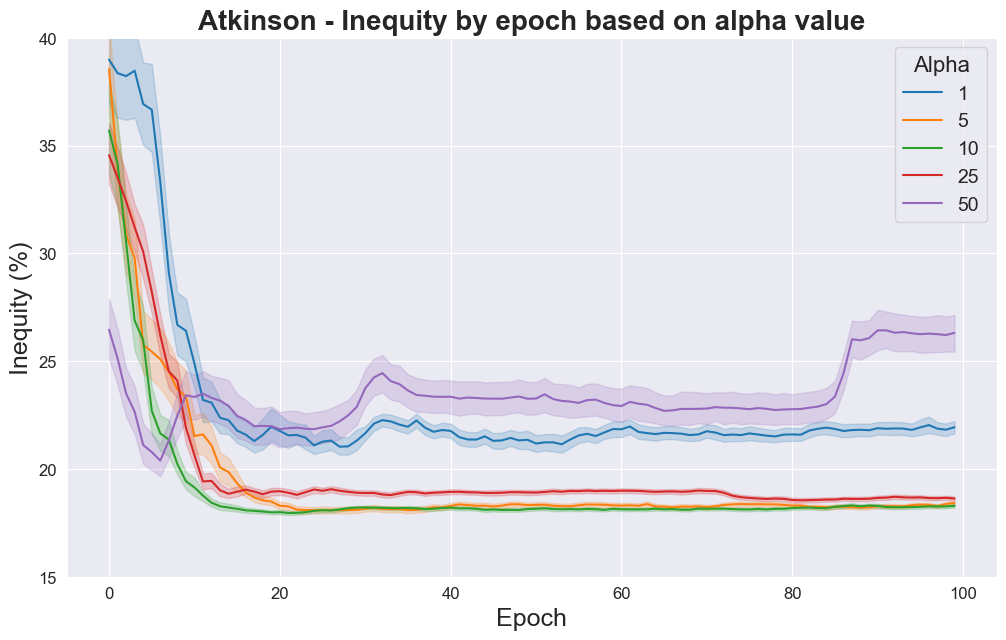

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Crear la figura con una relación de aspecto más ancha que alta


# Definir los FairIndex y sus respectivos ejes
fair_indices = ["Atkinson"]
titles = ["Jain", "Gini", "Atkinson"]  # No se encontraron erratas en estos títulos.

df_boxplot = get_plot_df(df_population, map_function_selector="Inequity")

# Generar los gráficos en sus respectivos ejes
for fair_index, title in zip(fair_indices, titles):
    df_filtered = df_boxplot[df_boxplot['FairIndex'] == fair_index]  # Filtrar datos

    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(1, 1, 1)

    sns.lineplot(
        data=df_filtered,
        x="Iteration",
        y="Inequity",
        hue="Alpha",
        estimator="mean",
        marker=None,
        palette="tab10",
        ax=ax
    )

    ax.set_ylim(15, 40)
    ax.set_title(f"{title} - Inequity by epoch based on alpha value", fontsize=20, fontweight='bold')      # Aumenta el tamaño del título del subplot
    ax.set_xlabel("Epoch", fontsize=18)     # Aumenta el tamaño del nombre del eje x
    ax.set_ylabel("Inequity (%)", fontsize=18)  # Aumenta el tamaño del nombre del eje y
    ax.tick_params(axis='both', labelsize=12)

    ax.set_yticks(np.linspace(15, 40, num=6))

    # Agregar una única leyenda fuera del área de los gráficos
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, fontsize=14, title="Alpha", title_fontsize=16)

    # Guardar el gráfico como PDF
    plt.savefig(f"../reports/mealpy/figures/pairwise_diff_alpha_{title}.pdf", format="pdf", bbox_inches="tight")

    plt.show()

ValueError: Could not interpret value `Fitness` for `y`. An entry with this name does not appear in `data`.

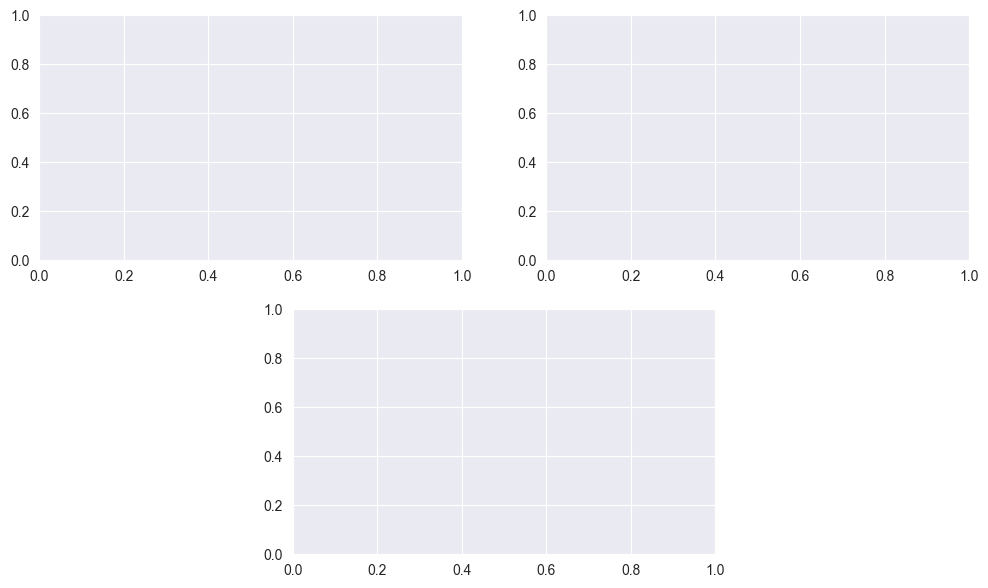

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Crear la figura con una relación de aspecto más ancha que alta
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2])
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

# Definir los FairIndex y sus respectivos ejes
fair_indices = ["Jain", "Gini", "Atkinson"]
titles = ["Jain", "Gini", "Atkinson"]  # No se encontraron erratas en estos títulos.
axes = [ax1, ax2, ax3]

# Generar los gráficos en sus respectivos ejes
for ax, fair_index, title in zip(axes, fair_indices, titles):
    df_filtered = df_boxplot[df_boxplot['FairIndex'] == fair_index]  # Filtrar datos

    sns.lineplot(
        data=df_filtered,
        x="Iteration",
        y="Fitness",
        hue="Alpha",
        estimator="mean",
        errorbar="sd",
        marker=None,
        palette="tab10",
        ax=ax
    )

    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=16, fontweight='bold')      # Aumenta el tamaño del título del subplot
    ax.set_xlabel("Epoch", fontsize=14)     # Aumenta el tamaño del nombre del eje x
    ax.set_ylabel("Index value", fontsize=14)  # Aumenta el tamaño del nombre del eje y

# Agregar un título general a la figura
fig.suptitle("Impact of the Hyperparameter 'Alpha' on Fairness Indices", y=0.95, fontsize=18, fontweight='bold')

# Ocultar leyenda en los tres gráficos
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
ax3.legend().set_visible(False)

# Agregar una única leyenda fuera del área de los gráficos
handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, title="Alpha", bbox_to_anchor=(0.25, 0.4))

# Ajustar el diseño para evitar solapamientos (ajustamos 'top' para dejar espacio al suptitle)
plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.85)

# Guardar el gráfico como PDF
plt.savefig("../reports/mealpy/figures/fair_index_alpha.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [24]:
import itertools
import numpy as np
import pandas as pd

# Se asume que df_history tiene la columna 'Alpha'
# Además, se asume que ru_names y frame_capacity ya están definidos

# Definir las columnas del nuevo DataFrame (agregamos 'Alpha')
columns = ['FairIndex', 'Alpha', 'Run', 'Fitness', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains'] + ru_names + ['Total Importance', 'Inequity', 'Assigned capacity']
summary_df = pd.DataFrame(columns=columns)

# Agrupar el historial por FairIndex y luego por Run
algo_grouped_df = df_history.groupby('FairIndex')
for algo_key, algo_group in algo_grouped_df:
    run_grouped_df = algo_group.groupby('Run')
    for run_label, run_group in run_grouped_df:
        alpha_grouped_df = run_group.groupby('alpha')
        for alpha_label, alpha_group in alpha_grouped_df:
            run = alpha_group['Run'].iloc[-1]
            # Extraemos el valor de Alpha (suponiendo que es constante en cada run)
            alpha = alpha_group['alpha'].iloc[-1]
            fitness = np.round(alpha_group['Fitness'].iloc[-1], 2)
            revenue = mptt.objective_function(alpha_group['Real'].iloc[-1])
            execution_time = np.round(alpha_group['ExecutionTime'].sum(), 2)
            scheduled_trains_array = alpha_group['Discrete'].iloc[-1]
            scheduled_trains = int(sum(scheduled_trains_array))
            real_solution = alpha_group['Real'].iloc[-1]

            # Actualizamos la planificación
            mptt.update_schedule(real_solution)

            # Obtener el diccionario de importancias (por RU)
            importance_dict = mptt.sum_importance(scheduled_trains_array)
            importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}
            total_importance = sum(importance_dict.values())

            # Calcular la suma de diferencias absolutas pairwise entre las importancias.
            pairwise_diff = 0
            for ru1, ru2 in itertools.combinations(ru_names, 2):
                pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

            # Se calcula max_ineq de acuerdo al número de RU (usado para normalizar la inequidad)
            if len(ru_names) % 2 == 0:
                max_ineq = (len(ru_names)**2) / 4
            else:
                max_ineq = (len(ru_names) // 2) * ((len(ru_names) + 1) // 2)

            # Construir la fila de datos
            row_data = [
                algo_key,
                alpha,
                run,
                fitness,
                revenue,
                execution_time,
                scheduled_trains
            ]
            # Agregar, para cada RU, el valor de la importancia (en %)
            for ru in ru_names:
                row_data.append(round(importance_dict.get(ru, 0) * 100, 2))
            # Columna de Total Importance
            row_data.append(round(total_importance / len(ru_names) * 100, 2))
            # Columna de Inequity (normalizada)
            row_data.append(round(pairwise_diff / max_ineq * 100, 2))
            # Columna de Assigned capacity
            capacity_usage = 0.0
            for ru in ru_names:
                capacity_usage += importance_dict.get(ru, 0) * frame_capacity[ru]
            row_data.append(capacity_usage)

            summary_df.loc[len(summary_df)] = row_data

# Ordenamos o mostramos el DataFrame resumen si se desea
# display(summary_df)

# Ahora agrupamos por FairIndex y Alpha para obtener un resumen de la inequidad
df_summary = summary_df.groupby(['FairIndex', 'Alpha'])['Inequity'].agg(['mean', 'std']).reset_index()

# Opcional: redondeamos a dos decimales
df_summary[['mean', 'std']] = df_summary[['mean', 'std']].round(2)

print(df_summary)

  FairIndex  Alpha   mean   std
0  Atkinson      1  23.17  3.15
1  Atkinson      5  18.48  0.45
2  Atkinson     10  18.69  1.15
3  Atkinson     25  21.72  6.84
4  Atkinson     50  25.98  7.51


In [39]:
df_summary.to_latex(float_format='%.2f')

'\\begin{tabular}{llrrr}\n\\toprule\n & FairIndex & Alpha & mean & std \\\\\n\\midrule\n0 & Atkinson & 1 & 26.23 & 5.73 \\\\\n1 & Atkinson & 5 & 20.81 & 3.27 \\\\\n2 & Atkinson & 10 & 18.64 & 2.75 \\\\\n3 & Atkinson & 25 & 17.17 & 0.56 \\\\\n4 & Atkinson & 50 & 17.44 & 0.78 \\\\\n5 & Gini & 1 & 24.06 & 8.34 \\\\\n6 & Gini & 5 & 17.55 & 0.80 \\\\\n7 & Gini & 10 & 17.13 & 0.54 \\\\\n8 & Gini & 25 & 22.95 & 13.20 \\\\\n9 & Gini & 50 & 27.97 & 22.66 \\\\\n10 & Jain & 1 & 25.38 & 5.48 \\\\\n11 & Jain & 5 & 17.85 & 1.57 \\\\\n12 & Jain & 10 & 16.96 & 0.62 \\\\\n13 & Jain & 25 & 16.89 & 0.14 \\\\\n14 & Jain & 50 & 18.56 & 2.12 \\\\\n15 & Revenue & 1 & 76.74 & 0.96 \\\\\n16 & Revenue & 5 & 76.74 & 0.96 \\\\\n17 & Revenue & 10 & 76.74 & 0.96 \\\\\n18 & Revenue & 25 & 76.74 & 0.96 \\\\\n19 & Revenue & 50 & 76.74 & 0.96 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [29]:
import itertools

mptt = MPTT(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behavior,
    line=line,
    safe_headway=10,
    fair_index="Revenue",
    alpha=25
)

# Mapeo de servicios a nombres de RU (por ejemplo, "RU1", "RU2", etc.)
service_tsps = {service.id: service.tsp.name for service in supply.services}
ru_names = sorted(set(service_tsps.values()))

# Definir las columnas del nuevo DataFrame:
# FairIndex, Run, Revenue, Execution Time (s.), Scheduled Trains + una columna por cada RU
columns = ['FairIndex', 'Run', 'Fitness', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains'] + ru_names + ['Total Importance', 'Pairwise Differences']
summary_df = pd.DataFrame(columns=columns)

# Agrupar el historial por FairIndex y luego por Run
algo_grouped_df = df_history.groupby('FairIndex')

for algo_key, algo_group in algo_grouped_df:
    run_grouped_df = algo_group.groupby('Run')
    for run_label, run_group in run_grouped_df:
        run = run_group['Run'].iloc[-1]
        fitness = np.round(run_group['Fitness'].iloc[-1], 2)
        revenue = mptt.objective_function(run_group['Real'].iloc[-1])
        execution_time = np.round(run_group['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_group['Discrete'].iloc[-1]
        scheduled_trains = int(sum(scheduled_trains_array))
        real_solution = run_group['Real'].iloc[-1]

        # Actualizamos la planificación (por si el método .sum_importance() depende de ello)
        mptt.update_schedule(real_solution)

        # Obtener el diccionario de importancias (por RU) a partir del vector booleano de servicios planificados.
        importance_dict = mptt.sum_importance(scheduled_trains_array)
        importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}

        total_importance = sum(importance_dict.values())

        # Calcular la suma de diferencias absolutas pairwise entre las importancias.
        pairwise_diff = 0
        for ru1, ru2 in itertools.combinations(ru_names, 2):
            pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

        # Construir la fila de datos:
        row_data = [
            algo_key,
            run,
            fitness,
            revenue,
            execution_time,
            scheduled_trains
        ]

        # Agregar, para cada RU (ordenados alfabéticamente), el valor de suma de importancia.
        for ru in ru_names:
            # Si no existe valor para algún RU, se asigna 0
            row_data.append(importance_dict.get(ru, 0))

        # Agregar la columna de Total Importance
        row_data.append(total_importance)
        # Agregar la columna de Pairwise Differences
        row_data.append(pairwise_diff)

        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Pairwise Differences', ascending=True)
display(summary_df)
print()

,FairIndex,Run,Fitness,Revenue,Execution Time (s.),Scheduled Trains,RU1,RU2,RU3,RU4,RU5,Total Importance,Pairwise Differences
4,Atkinson,5,4249.06,5306.896008,403.43,25,0.479898,0.483329,0.459372,0.256653,0.492383,2.171636,0.990832
12,Jain,3,4365.58,4258.683913,409.10,24,0.485044,0.481168,0.459372,0.256653,0.492383,2.174621,0.994261
9,Gini,5,3892.86,4708.591163,400.53,24,0.485201,0.476965,0.459372,0.256653,0.492383,2.170576,0.994576
10,Jain,1,3824.04,3701.305220,410.83,22,0.467530,0.487326,0.459372,0.256653,0.492383,2.163265,0.998826
2,Atkinson,3,4602.51,4134.503726,405.65,25,0.488014,0.476965,0.459372,0.256653,0.492383,2.173388,1.000202
11,Jain,2,4121.37,4036.172771,411.57,23,0.488340,0.480621,0.459372,0.256653,0.492383,2.177370,1.000854
8,Gini,4,3359.80,3677.707254,407.35,23,0.488467,0.488369,0.459372,0.256653,0.492383,2.185245,1.001108
1,Atkinson,2,4507.93,4231.534864,406.73,25,0.485850,0.491230,0.459372,0.256653,0.492383,2.185489,1.006635
14,Jain,5,4388.48,4991.071963,404.64,25,0.492965,0.489894,0.459372,0.256653,0.492383,2.191269,1.011269
7,Gini,3,4210.95,5206.928334,403.86,25,0.497622,0.489007,0.459372,0.256653,0.492383,2.195038,1.029895


In [ ]:
# Table with results by run

mptt = MPTT(requested_schedule=requested_schedule,
                revenue_behavior=revenue_behavior,
                line=line,
                safe_headway=10,
                fair_index="Revenue")

service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['FairIndex', 'Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += sorted(set(service_tsps.values()))
columns += [f"{tsp}_equity" for tsp in sorted(set(service_tsps.values()))]
summary_df = pd.DataFrame(columns=columns)

algo_grouped_df = df_history.groupby('FairIndex')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = np.round(run_grouped_df.get_group(group)['Fitness'].iloc[-1], 2)
        execution_time = np.round(run_grouped_df.get_group(group)['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        mptt.update_schedule(real_solution)
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in sorted(service_tsps.values())}
        for i, service in enumerate(mptt.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(mptt.requested_schedule[service].keys())[0]
            delta_dt += abs(mptt.updated_schedule[service][departure_station][1] -
                            mptt.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(mptt.requested_schedule[service].keys()):
                if j == 0 or j == len(mptt.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(mptt.updated_schedule[service][stop][1] - mptt.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100, 2)} %"

        frame_capacity_dict = {}
        for tsp in services_by_tsp:
            frame_capacity_dict[f"{tsp}_equity"] = f"{np.round(services_by_tsp[tsp] / 25 * 100, 2)}"

        row_data =  [algo_group[0],
                     run,
                     revenue,
                     execution_time,
                     scheduled_trains,
                     np.round(delta_dt, 2),
                     np.round(delta_tt, 2),
                     *list(percentages_by_tsp.values()),
                     *list(frame_capacity_dict.values())]
        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)
print()

In [ ]:
frame_capacity

In [ ]:
# Supongamos que frame_capacity_target es un diccionario como:

sm = RevenueMaximization(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behavior,
    line=line,
    safe_headway=10
)

# Diccionario para relacionar cada servicio con el nombre de su RU.
service_tsps = {service.id: service.tsp.name for service in supply.services}

# Definir las columnas del dataframe de resumen.
base_columns = ['FairIndex', 'Run', 'Revenue', 'Execution Time (s.)',
                'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)', 'Overall Fairness']
# Ordenamos alfabéticamente los nombres de RU
ru_names = sorted(set(service_tsps.values()))
# Se añaden columnas con el porcentaje alcanzado (a nivel de RU) y
# columnas informativas con el nombre _equity para cada RU.
summary_columns = base_columns + ru_names + [f"{tsp}_equity" for tsp in ru_names]
summary_df = pd.DataFrame(columns=summary_columns)

# Agrupamos df_history por FairIndex (cada grupo corresponde a un método/algoritmo)
algo_grouped_df = df_history.groupby('FairIndex')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for run_label, run_group in run_grouped_df:
        # Extraer valores de la ejecución
        run = run_group['Run'].iloc[-1]
        revenue = np.round(run_group['Fitness'].iloc[-1], 2)
        execution_time = np.round(run_group['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_group['Discrete'].iloc[-1]
        scheduled_trains = int(sum(scheduled_trains_array))
        real_solution = run_group['Real'].iloc[-1]

        # Actualizar la planificación con la solución real (se ignoran los servicios no programados)
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains_array))
        delta_dt = 0.0
        delta_tt = 0.0

        # Inicializar contadores para cada RU (por ejemplo, 'RU1', 'RU2', etc.)
        services_by_tsp = {tsp: 0 for tsp in ru_names}

        # Para cada servicio del plan solicitado, si está programado se acumulan los deltas y se cuenta la RU
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            # Para el primer stop se calcula el delta en DT
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(
                sm.updated_schedule[service][departure_station][1] -
                sm.requested_schedule[service][departure_station][1]
            )
            # Para los stops intermedios se acumulan los deltas en TT
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(
                    sm.updated_schedule[service][stop][1] -
                    sm.requested_schedule[service][stop][1]
                )
            # Incrementar contador según el RU del servicio
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1

        # Calcular el porcentaje alcanzado para cada RU comparando con su capacidad marco.
        # Por ejemplo, si para 'RU1' se programaron 15 servicios y la capacidad marco es 30, se alcanza el 50%.
        percentages_by_tsp = {}
        ru_equity = {}  # Almacenará el valor numérico (por ejemplo, 50.0) para cada RU
        for tsp in ru_names:
            target = services_by_ru[tsp]  # capacidad marco del RU
            achieved = services_by_tsp[tsp]
            percentage = np.round(achieved / target * 100, 2) if target != 0 else 0.0
            percentages_by_tsp[tsp] = f"{percentage} %"
            ru_equity[tsp] = percentage

        # Calcular el índice de equidad global (Overall Fairness) usando la fórmula de Jain:
        # J = (sum(r_i)^2) / (n * sum(r_i^2))
        r_values = list(ru_equity.values())
        n = len(r_values)
        sum_r = sum(r_values)
        sum_r_sq = sum([r**2 for r in r_values])
        overall_fairness = (sum_r**2) / (n * sum_r_sq) if sum_r_sq != 0 else 0

        # Preparar la fila de datos. Se agregan:
        # - Las métricas generales
        # - Para cada RU, el porcentaje alcanzado (según el orden en ru_names)
        # - Para cada RU, se incluye una columna con el nombre <RU>_equity que muestra el mismo valor numérico
        row_data = [
            algo_group[0],            # FairIndex (método)
            run,
            revenue,
            execution_time,
            scheduled_trains,
            np.round(delta_dt, 2),
            np.round(delta_tt, 2),
            np.round(overall_fairness, 4)  # Se puede multiplicar por 100 si se prefiere porcentaje
        ]
        # Agregar los porcentajes por RU
        for tsp in ru_names:
            row_data.append(percentages_by_tsp[tsp])
        # Agregar las columnas de _equity (se puede mostrar el valor numérico)
        for tsp in ru_names:
            row_data.append(ru_equity[tsp])

        # Añadir la fila al dataframe resumen
        summary_df.loc[len(summary_df)] = row_data

# Ordenar el dataframe de salida según el Overall Fairness de forma descendente
summary_df = summary_df.sort_values('Overall Fairness', ascending=False)
display(summary_df)
print()


In [ ]:
summary_df.to_latex()

In [ ]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('FairIndex')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        
        print(f"Global {algo_group[0]} status:")
        
        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
        
        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
        
        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
        
        max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()
        
get_global_status(df_history)

In [ ]:

def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby('FairIndex')
    
    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')
        
        run_times = run_grouped_df['ExecutionTime'].sum()
        
        run_revenues = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        
        result = {
            'FairIndex': algo_name,
            'Mean Execution Time (seconds)': round(run_times.mean(), 2),
            'Std Execution Time (seconds)': round(run_times.std(), 2),
            'Mean Fitness (revenue)': round(run_revenues.mean(), 2),
            'Std Fitness (revenue)': round(run_revenues.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }
        
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Short by column 'Mean Fitness' 
    results_df = results_df.sort_values(by='Mean Fitness (revenue)', ascending=False).reset_index(drop=True)
    return results_df

results_df = get_global_status_as_dataframe(df_history)
results_df

In [ ]:
results_df.to_latex()

In [ ]:
sns_line_plot(df=df_history,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(1500,4500),
              save_path=Path('../reports/mealpy/mealpy_convergence_equity.pdf'),
              fig_size=(10, 9))

In [ ]:
df_history.head()

In [ ]:
N = 50  # Número de saltos que quieres aplicar

algo_1_vals = df_history[df_history['Algo'] == 'Simulated Annealing'] \
    .groupby(['Run', 'Iteration'])['Fitness'].last() \
    .groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()

algo_1_vals

In [ ]:
algo_df = df_history[df_history['Algo'] == 'Genetic Algorithm']

algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()

algo_vals

In [ ]:
print(len(algo_vals))

In [ ]:
algo_df = df_history[df_history['Algo'] == 'Simulated Annealing']

N = 50
algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()

algo_vals

In [ ]:
print(len(algo_vals))

In [ ]:
# Confusion Matrix stadistical differences 

from scipy import stats

def get_epoch_last_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(list).sum()
    else:
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()
    return algo_vals

def get_epoch_best_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()
    else:
        algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()
    return algo_vals

matrix_wilcoxon = []
matrix_p_values = []
for algo_name, algo in mp_algos.items():
    row_w = []
    row_p = []
    for algo_name_2, algo_2 in mp_algos.items():
        if algo_name == algo_name_2:
            row_w.append(np.nan)
            row_p.append(np.nan)
            continue
        
        algo_1_vals = get_epoch_best_fitness(df_history, algo_name)
        algo_2_vals = get_epoch_best_fitness(df_history, algo_name_2)
        stat, p_value = stats.wilcoxon(algo_1_vals, algo_2_vals)
        row_w.append(round(stat))
        row_p.append(round(p_value, 3))
    matrix_wilcoxon.append(row_w)
    matrix_p_values.append(row_p)

In [ ]:
print("Wilcoxon Matrix")
df_wilcoxon = pd.DataFrame(matrix_wilcoxon, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_wilcoxon)

In [ ]:
print("P-Values Matrix")
df_p_values = pd.DataFrame(matrix_p_values, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_p_values)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df_wilcoxon, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_wilcoxon.columns, rotation=30, ha='right')
plt.yticks(range(10), df_wilcoxon.index)
plt.title('Confusion Matrix - Wilcoxon Statistic', fontweight='bold', fontsize=18)

for i in range(df_wilcoxon.shape[0]):
    for j in range(df_wilcoxon.shape[1]):
        value = df_wilcoxon.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{int(value)}"
            text_color = 'black' if value > 50000 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/wilcoxon_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
# Visualización con matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(df_p_values, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_p_values.columns, rotation=30, ha='right')
plt.yticks(range(10), df_p_values.index)
plt.title('Confusion Matrix - P-values', fontweight='bold', fontsize=18)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.4 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(12, 10))
plt.imshow(df_p_values, cmap='seismic', interpolation='nearest')
plt.colorbar(label='P-value', shrink=0.8)
plt.xticks(range(df_p_values.shape[1]), df_p_values.columns, rotation=45, ha='right', fontsize=10)
plt.yticks(range(df_p_values.shape[0]), df_p_values.index, fontsize=10)
plt.title('Matrix of P-values Between Algorithms', fontweight='bold', fontsize=20)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            display_value = "NaN"
            text_color = 'white'
            rect_color = (0.5, 0.5, 0.5)
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.3 and value < 0.7 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color, fontsize=8)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, df_p_values.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, df_p_values.shape[0], 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_improved.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
stat, p_value = stats.wilcoxon(genetic_revenues_mean, acor_revenues_mean)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

In [ ]:
# Select a solution from df_history:
algo_name = 'Genetic Algorithm'
run = 1
iteration = 99

filtered_row = df_history[
    (df_history["Algo"] == algo_name) &
    (df_history["Run"] == run) &
    (df_history["Iteration"] == iteration)
]

# Get values from columns "Real" & "Discrete"
if not filtered_row.empty:
    real_value = filtered_row["Real"].iloc[0]
    discrete_value = filtered_row["Discrete"].iloc[0]
    ga_best_sol = Solution(real=real_value, discrete=discrete_value)
    print(f"Real: {real_value}, Discrete: {discrete_value}")
else:
    print("Row not found matching the provided parameters.")

In [ ]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behavior=revenue_behavior,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=ga_best_sol)

sm.update_schedule(solution=ga_best_sol)

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if ga_best_sol.discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'{tt_file_name}_25_new.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

In [ ]:
final_supply = Supply.from_yaml(supply_config_file)

In [ ]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_ga_25.pdf'))

In [ ]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'{tt_file_name}_equity.yml')

In [ ]:
#!snakeviz profile.pstat